# Plots for mutation-transmissibility paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update        # ~30 minutes on CPU (mostly sequence alignment)
python mutrans.py  # ~2 hours on GPU (mostly MCMC)
```

In [1]:
import datetime
import math
import pickle
import logging
from collections import Counter, OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
torch.set_default_dtype(torch.double)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
# matplotlib.rcParams["axes.linewidth"] = 0.5
matplotlib.rcParams["lines.markeredgewidth"]
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = [
    # 'Helvetica Neue',
    # 'Hiragino Sans',
    # 'Heiti TC',
    'Arial', 'Avenir', 'DejaVu Sans',
]

## Theory

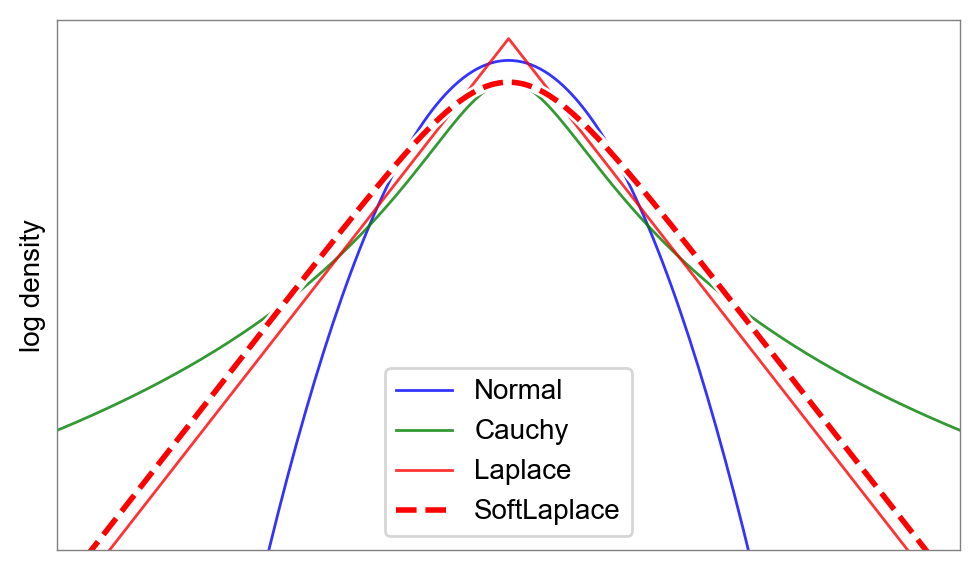

In [2]:
x = torch.linspace(-6, 6, 201)
plt.figure(figsize=(5, 3))
plt.plot(x, dist.Normal(0, 1).log_prob(x), 'b-', lw=1, label="Normal", alpha=0.8)
plt.plot(x, dist.Cauchy(0, 1).log_prob(x), 'g-', lw=1, label="Cauchy", alpha=0.8)
plt.plot(x, dist.Laplace(0, 1).log_prob(x), 'r-', lw=1, label="Laplace", alpha=0.8)
plt.plot(x, dist.SoftLaplace(0, 1).log_prob(x), 'w-', lw=4)
plt.plot(x, dist.SoftLaplace(0, 1).log_prob(x), 'r--', lw=2, label="SoftLaplace")
plt.ylabel("log density")
plt.ylim(-6, -0.5)
plt.xlim(-6, 6)
plt.xticks(())
plt.yticks(())
plt.legend(loc='lower center')
plt.tight_layout()
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

## Load data

In [3]:
%%time
dataset = mutrans.load_gisaid_data()
dataset.update(mutrans.load_jhu_data(dataset))
print(dataset.keys())
locals().update(dataset)
print(len(mutations))

     6145 Loading data
     7009 Training on 1133634 rows with columns:
     7010 lineage, virus_name, accession_id, collection_date, location, add_location, day
     7105 Loaded torch.Size([1265, 2300]) feature matrix
    19686 Keeping 1133634/1133634 rows
    19718 Keeping 288/309 regions
    20187 Loaded 453 x 3616 daily case data, totaling 24505604312.0
    20188 Joining GISAID and JHU region codes
    20459 Matching 288 GISAID regions to 3616 JHU fuzzy regions


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'feature_order', 'feature_order_max', 'lineage_id', 'lineage_id_inv', 'local_time', 'daily_cases', 'weekly_cases'])
2300
CPU times: user 13.9 s, sys: 765 ms, total: 14.6 s
Wall time: 14.4 s


In [4]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)

Sanity checking case count time series:

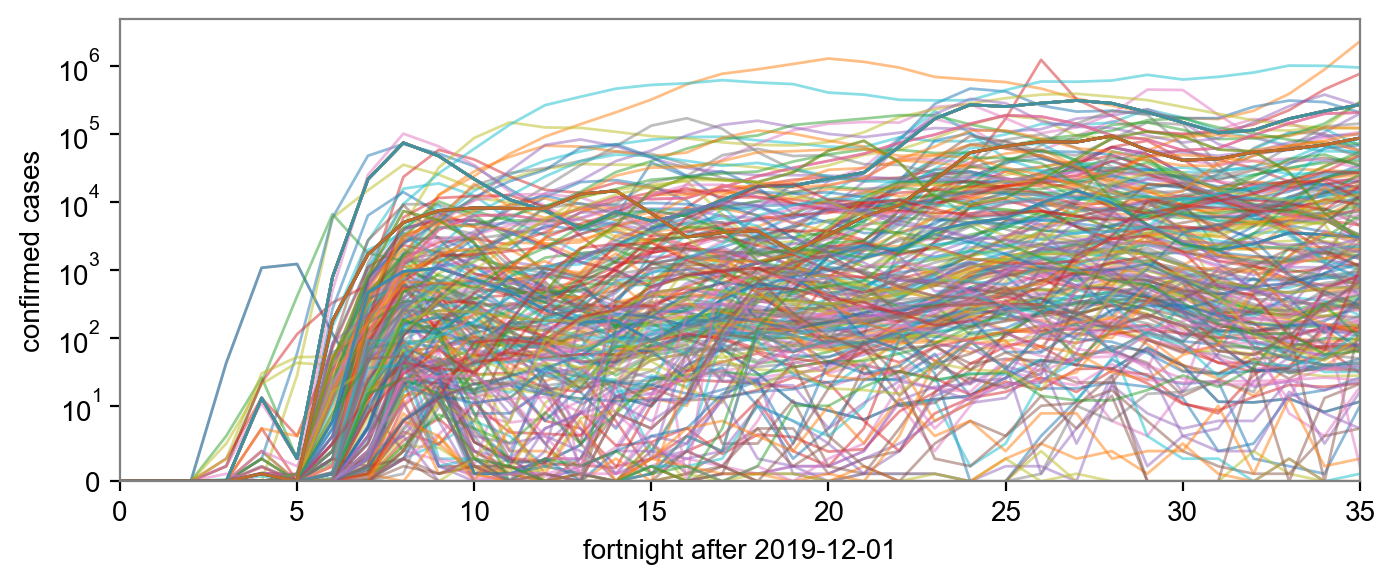

In [5]:
plt.figure(figsize=(8, 3))
plt.plot(weekly_cases, lw=1, alpha=0.5)
plt.yscale("symlog", linthresh=10)
plt.ylim(0, None)
plt.xlim(0, len(weekly_cases) - 1)
plt.xlabel("fortnight after 2019-12-01")
plt.ylabel("confirmed cases");

In [ ]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [ ]:
fits = torch.load("results/mutrans.pt", map_location="cpu")
svi_fit = list(fits.values())[0]
mcmc_fit = list(fits.values())[1]
for key in fits:
    print(key)
print("SVI:", svi_fit.keys())
print("MCMC:", mcmc_fit.keys())
print(mcmc_fit["diagnostics"].keys())
print(mcmc_fit["diagnostics"]["rate_coef"].keys())
print(mcmc_fit["median"].keys())
print(len(svi_fit["mutations"]))

## Assess model fitness

In [ ]:
for key, value in fits.items():
    median = value["median"]
    plt.figure(figsize=(8, 2))
    plt.plot(value["losses"], lw=1)
    plt.xlabel("learning step (duration = {:0.1f} minutes)".format(value["walltime"]/60))
    plt.ylabel("loss")
    plt.title("{} (conc. = {:0.3g}, f.scale = {:0.3g})".format(
        key[0],
        median["concentration"].item(),
        median["feature_scale"].item(),
    ));

In [ ]:
mcmc_fits = []
for key, fit in fits.items():
    if key[0] != "mcmc":
        continue
    max_tree_depth = key[3]
    n_eff = fit["diagnostics"]["rate_coef"]["n_eff"]
    mcmc_fits.append((max_tree_depth, n_eff))
fig, axes = plt.subplots(len(mcmc_fits), 1, sharex=True, figsize=(8, 3 + len(mcmc_fits)))
if len(mcmc_fits) == 1:
    axes = [axes]
for (max_tree_depth, n_eff), ax in zip(mcmc_fits, axes):
    if torch.isnan(n_eff).any():
        print("ERROR n_eff is NAN")
        continue
    base = 2 ** 0.2
    bins = [base ** i for i in range(int(n_eff.log().min() / math.log(base)),
                                     int(n_eff.log().max() / math.log(base)) + 2)]
    ax.hist(n_eff.numpy(), bins=bins)
    ax.set_xscale("log")
    ax.set_ylabel(f"max tree depth = {max_tree_depth}")
axes[0].set_title("MCMC effective sample size of rate_coef")
axes[-1].set_xlabel("effective sample size")
plt.subplots_adjust(hspace=0);

In [ ]:
if torch.isnan(n_eff).any():
    print("ERROR n_eff is NAN")
else:
    sigma = mcmc_fit["mean"]["rate_coef"] / mcmc_fit["std"]["rate_coef"]
    plt.scatter(sigma.numpy(), n_eff.numpy(), 20, lw=0, alpha=0.3)
    plt.ylabel("effective sample size")
    plt.xlabel("statistical significance = |μ|/σ")
    plt.xscale("symlog", linthresh=2)
    plt.yscale("log")
    plt.title("Does N_eff depend on the significance metric?")
    plt.tight_layout();

In [ ]:
plt.scatter(
    svi_fit["mean"]["rate_coef"].numpy(),
    mcmc_fit["mean"]["rate_coef"].numpy(),
    10, lw=0, alpha=0.5
)
x0 = min(svi_fit["mean"]["rate_coef"].min().item(),
         mcmc_fit["mean"]["rate_coef"].min().item())
x1 = max(svi_fit["mean"]["rate_coef"].max().item(),
         mcmc_fit["mean"]["rate_coef"].max().item())
plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2, zorder=-100)
plt.xscale("symlog")
plt.yscale("symlog")
plt.title("SVI versus MCMC: μ = effect size")
plt.xlabel("SVI estimate")
plt.ylabel("MCMC estimate")
plt.tight_layout()

In [ ]:
svi_sigma = svi_fit["mean"]["rate_coef"] / svi_fit["std"]["rate_coef"]
mcmc_sigma = mcmc_fit["mean"]["rate_coef"] / mcmc_fit["std"]["rate_coef"]
plt.scatter(svi_sigma.numpy(), mcmc_sigma.numpy(), 10, lw=0, alpha=0.5)
x0 = min(svi_sigma.min().item(), mcmc_sigma.min().item())
x1 = max(svi_sigma.max().item(), mcmc_sigma.max().item())
plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2, zorder=-100)
plt.xscale("symlog")
plt.yscale("symlog")
plt.title("SVI versus MCMC: |μ|/σ = statistical significance")
plt.xlabel("SVI estimate")
plt.ylabel("MCMC estimate")
plt.tight_layout()

## Interpreting results

In [ ]:
def plot_coefficients(name, rate_coef):
    xs, idx = rate_coef.sort(0)
    assert len(idx) == len(mutations)
    plt.figure(figsize=(6, 6))
    plt.title(f"{name} regression coefficients (mutations)")
    plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
    plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
    plt.xlabel(f"rank among {len(xs)} mutations")
    plt.ylabel("Δ transmissibility")  # TODO convert to Δ log R

    I = len(idx)
    y0 = float(xs.min())
    y1 = float(xs.max())
    N = 50
    for i in range(N):
        x = -I / 8
        y = y0 + (y1 - y0) * i / (N - 1)
        plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
        plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(I - N, I):
        x = I + I / 8
        y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
        plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
        plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
    plt.xlim(-0.35 * I, 1.35 * I)
    plt.xticks(())

plot_coefficients("SVI", svi_fit["median"]["rate_coef"])
plot_coefficients("MCMC", mcmc_fit["median"]["rate_coef"])

In [ ]:
def plot_decomposition(median, queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        assert len(names) == 1, place_query
        id_ = location_id[names[0]]
        rate = median["rate"]
        # FIXME this ignores region population when aggregating:
        init = median["init"][id_]
        assert init.shape == rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        local_time = time + dataset["local_time"][-1, id_]
        portion = (init + rate * local_time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_xticks((0, 1, 2, 3))
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(mcmc_fit["median"],
                   ["Mass", "Calif", "Texas", "Florida", "New York"])

In [ ]:
def plot_baby_volcano(mean, std, linthresh=5):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    mask = (xs > 0) & (ys > p95)

    plt.figure(figsize=(4, 4), dpi=300)
    plt.title(f"Δ transmissibility of {len(mutations)} mutations")
    plt.scatter(xs[~mask], ys[~mask], 5, color='#aaaaaa', lw=0)
    plt.scatter(xs[mask], ys[mask], 5, color='black', lw=0)
    plt.xlabel("effect size")
    plt.ylabel("statistical significance")
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    # yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100] if y < y1]
    # plt.yticks(yticks, list(map(str, yticks)))
    plt.yticks(())
    plt.xticks((-10, -5, 0, 5, 10))
    for spine in plt.gca().spines.values():
        spine.set_linewidth(0.5)
    plt.axhline(p95, color='k', linestyle='--', alpha=0.3, zorder=-10)
    plt.text(0.8 * x0 + 0.2 * x1, p95 * 0.85, "95% probabililty\nof correct sign",
             fontsize=10, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
    plt.tight_layout()

plot_baby_volcano(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"])

In [ ]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=60):
    ys = mean.abs() / std
    xs = mean * 5.5 / 365.25
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    plt.text(0.2 * x0 + 0.8 * x1, p95 * 0.95, "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
        name = mutations[int(idx_neg[i])]
        plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"], linthresh=5,
             filenames=["paper/volcano.png"])

In [ ]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=50, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots scaled by effect size)")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 8 * mean[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items()}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.8 + y1 * 0.2
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"],
               filenames=["paper/manhattan.png"])

In [ ]:
def plot_upper_east_side(mean, std, top_k=120, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id["N"]) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of mutations within N gene"
              " (dots scaled by effect size)")
    plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 8 * mean[mask].numpy(),
                color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    z0 = 28800
    z1 = 29000
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene != "N":
            continue
        if z0 < x < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    special.sort(reverse=True)
    lb = min(y for (y, _, _) in special)
    ub = max(y for (y, _, _) in special)
    lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
    for i, (y, x, name) in enumerate(special):
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
        x_label = z1
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    start, end = GENE_TO_POSITION["N"]
    plt.xlim(start, end)
    xticks = [start]
    while xticks[-1] + 150 < end:
        xticks.append(xticks[-1] + 150)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel("amino acid position within N gene")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_upper_east_side(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"],
                     filenames=["paper/upper_east_side.png"])

In [ ]:
def plot_prevalence(filenames=()):
    rate = mcmc_fit["median"]["rate"]
    rate = rate - rate[lineage_id["A"]]
    R = (rate * 5.5 / 365.25).exp()
    init = mcmc_fit["median"]["init"] + dataset["local_time"][-2, :, None] * rate
    init = init - init.logsumexp(-1, True)
    cases = torch.einsum("ps,p->s", init.exp(), weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        if cases[i] <= 1.1:
            continue
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("log")
    #plt.xscale("log")
    plt.ylim(1, None)
    plt.xlim(0.9, None)
    xticks = (0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5)
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)
    
plot_prevalence(["paper/strain_prevalence.png"])

## Extracting a table of top mutations and their stories

In [ ]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [ ]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [ ]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["rate_coef"]
    sigma = mean / fit["std"]["rate_coef"].clamp(min=1e-8)
    lb, ub = stats.confidence_interval(0.95, fit["samples"]["rate_coef"])
    R_RA = (mean * 5.5 / 365.25).exp()  # 5.5 is estimated generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("mean", "{:0.6g}"),
        ("95% ci lower", "{:0.6g}"),
        ("95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], mean[i], lb[i], ub[i], R_RA[i], ", ".join(emerged)
            ))

write_mutation_table(mcmc_fit, "paper/mutations.tsv")
pd.read_csv("paper/mutations.tsv", sep="\t")

In [ ]:
print(columns.keys())

In [ ]:
lineage_bday = {}
for lineage, day in zip(columns["lineage"], columns["day"]):
    lineage = pangolin.decompress(lineage)
    lineage_bday[lineage] = min(lineage_bday.get(lineage, math.inf), day)
start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
lineage_bday = {
    lineage: (start_date + datetime.timedelta(days=day)).strftime("%Y-%m-%d")
    for lineage, day in lineage_bday.items()
}

In [ ]:
def write_strain_table(fit, filename):
    assert filename.endswith(".tsv")
    R_mean = (fit["mean"]["rate"] * 5.5 / 365.25).exp()  # 5.5 is estimated generation time.
    R_sample = (fit["samples"]["rate"] * 5.5 / 365.25).exp()
    RA = R_mean[lineage_id["A"]]
    R_RA = R_mean / RA
    lb, ub = stats.confidence_interval(0.95, R_sample / RA)
    logits = fit["mean"]["init"] + dataset["local_time"][..., None] * fit["mean"]["rate"]
    probs = (logits - logits.logsumexp(-1, True)).exp()
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("R / R_A", "{:.6g}"),
        ("95% ci lower", "{:.6g}"),
        ("95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_mean.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            f.write(row.format(
                rank + 1, lineage,
                R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                lineage_bday[pangolin.decompress(lineage)],
            ))

write_strain_table(mcmc_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

In [ ]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

In [ ]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

In [ ]:
def correlation(x, y):
    x = (x - x.mean()) / x.std()
    y = (y - x.mean()) / y.std()
    return (x * y).mean()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = mcmc_fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
y = y * 5.5 / 365.25
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing transmissibility against theses deep scanning results.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("transmissibility = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(mcmc_fit)

## Fit on subsets of data

In [ ]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))

In [ ]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

In [ ]:
aliases = [
    "excluding the UK",
    "excluding the USA",
    "only the UK",
    "only the USA",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, holdout_fits.values()))

In [ ]:
def plot_mutation_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["rate_coef"] * 5/5 / 365.25
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig, axes = plt.subplots(1, len(holdouts), figsize=(11, 3), sharey=True)
    fig.suptitle("Δ log R for {} mutations estimated from full versus subsets of data"
                 .format(len(fit1["mutations"])))
    for ax, (name, fit2), mean2 in zip(axes, holdouts.items(), means):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit, mean in ((fit1, mean1), (fit2, mean2)):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(mean[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 60, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.4, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(svi_fit, holdout_fits, ["paper/agreement.png"])

In [ ]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["median"]["rate"]
        return ((rate - rate[lineage_id["A"]]) * 5.5 / 365.25).exp()
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig, axes = plt.subplots(1, len(holdouts), figsize=(11, 3), sharey=True)
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages esimated from full versus subsets of data"
                 .format(len(lineage_id)))
    for ax, name, mean2 in zip(axes, holdouts, means):
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(mean2.numpy(), mean1.numpy(), 60, alpha=1, lw=0, color="white")
        ax.scatter(mean2.numpy(), mean1.numpy(), 30, alpha=0.4, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(mean1, mean2)))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(mcmc_fit, holdout_fits, ["paper/agreement.png"])

In [ ]:
def plot_mutation_subset_boxplot(fits, rankby="s", top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    if rankby == "s":
        rankby = best_fit["mean"]["rate_coef"] / best_fit["std"]["rate_coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["rate_coef"]
        title = f"Top {top_k} most transmissible mutations"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate_coef"].T[top_indices].T
        else:
            mean = fit["mean"]["rate_coef"][top_indices]
            std = fit["std"]["rate_coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        samples = samples * 5.5 / 365.25
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'lightgreen', 'pink']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("Δ log R")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

plot_mutation_subset_boxplot({
    "World": mcmc_fit,
    # TODO infer these via MCMC
    "World w/o UK": holdout_fits['excluding the UK'],
    "UK only": holdout_fits['only the UK'],
}, filenames=["paper/mutation_uk_boxplot.png"])
plot_mutation_subset_boxplot({
    "World": mcmc_fit,
    # TODO infer these via MCMC
    "World w/o USA": holdout_fits['excluding the USA'],
    "USA only": holdout_fits['only the USA'],
}, filenames=["paper/mutation_usa_boxplot.png"])

In [ ]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    top_indices = best_fit["mean"]["rate"].sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate"].T[top_indices].T
        else:
            mean = fit["median"]["rate"][top_indices]
            std = fit["std"]["rate"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - fit["median"]["rate"][lineage_id["A"]]
        samples = (samples * 5.5 / 365.25).exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'lightgreen', 'pink']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} most transmissible lineages")
    for f in filenames:
        plt.savefig(f)

plot_strain_subset_boxplot({
    "World": mcmc_fit,
    # TODO infer these via MCMC
    "World w/o UK": holdout_fits['excluding the UK'],
    "UK only": holdout_fits['only the UK'],
}, filenames=["paper/strain_uk_boxplot.png"])
plot_strain_subset_boxplot({
    "World": mcmc_fit,
    # TODO infer these via MCMC
    "World w/o USA": holdout_fits['excluding the USA'],
    "USA only": holdout_fits['only the USA'],
}, filenames=["paper/strain_usa_boxplot.png"])